# Comparison between Nestorov and normal momentum approaches 

## Import libreries and define global variables

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from utils import get_data, onehot_encoding, grid_search, save_dict_to_file, load_dict_from_file
from Layer import Layer, Input
from functions import accuracy, MSE, MEE
import pandas as pd

In [31]:
DIR = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/' # Directory of the package.

## Import datasets

### Import MONK datasets

In [32]:
df = get_data(f'{DIR}data/MONK/monks-1.train')
df_test = get_data(f'{DIR}data/MONK/monks-1.test')

X_train_monk, y_train_monk = df.drop(columns=['target','id']).to_numpy().T, df['target'].apply(lambda x: int(x)).to_numpy().T
X_test_monk, y_test_monk = df_test.drop(columns=['target','id']).to_numpy().T, df_test['target'].apply(lambda x: int(x)).to_numpy().T

### Import CUP dataset

Define the fraction of dataset which will represent the internal test set.

In [33]:
test_frac = 1/4

In [34]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv(f"{DIR}data/ML-CUP23-TR.csv", names=names, comment='#')

targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

df = df.sample(frac=1)

train_test_div = round((1-test_frac) * df.shape[0])

X_train_cup, y_train_cup = df[:train_test_div][features].to_numpy().T, df[:train_test_div][targets].to_numpy().T
X_test_cup, y_test_cup = df[train_test_div:][features].to_numpy().T, df[train_test_div:][targets].to_numpy().T

## Data preprocessing

### MONK preprocessing

Process one hot encoding on training and test sets.

In [35]:
X_train_monk = onehot_encoding(X_train_monk)
X_test_monk = onehot_encoding(X_test_monk)

### CUP preprocessing

Decide which data preprocessing method apply to cup training set:
+ MinMax normalization (preprocessing = 1)
+ Standardization (preprocessing = 2)

In [36]:
def standardize(input_array):
    """
    Standardize each feature in an input array using Z-score standardization.

    Parameters:
    - input_array (numpy.ndarray): Input array with dimensions (features, samples).

    Returns:
    - numpy.ndarray: Standardized input array.
    """
    mean_vals = np.mean(input_array, axis=1, keepdims=True)
    std_dev_vals = np.std(input_array, axis=1, keepdims=True)

    # Ensure no division by zero
    std_dev_vals[std_dev_vals == 0] += 1e-6

    standardized_array = (input_array - mean_vals) / std_dev_vals

    return standardized_array


In [37]:
def minmax_norm(input_array):
    X_train_norm = []
    for elem in input_array:
        X_train_norm.append((elem - np.min(elem)) / (np.max(elem) - np.min(elem)))
    return np.array(X_train_norm)

In [38]:

X_train_norm = minmax_norm(X_train_cup)
X_test_norm = minmax_norm(X_test_cup)

X_train_stand = standardize(X_train_cup)
X_test_stand = standardize(X_test_cup)

## CUP

Define training and model hyperparameters

In [39]:
orig_params = {'hidden_dim': 50,
        'hidden_act_func': 'tanh',
        'hidden_dim2': 50,
        'hidden_act_func2' : 'tanh',
        'eta': 0.001,
        'lam': 0.000,
        'alpha': 0.9,
        'n_batch': 150,
        'use_opt':0,
        'nest': True,
        'l1_reg' : False,
        'epochs' : 500,
        'loss' : 'MSE',
        'output_act_func': 'lin'
        }
seed = np.random.randint(10,1000)

### No normalization

Build model

In [40]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

init_weights_list = model.get_initial_weights_list()

Training:

In [41]:
np.random.seed(seed)
history_nonorm = model.train(X_train_cup, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.248e+02, val_loss: 6.237e+02; train_MEE: 3.838e+01, val_MEE: 3.847e+01  lr : 0.001
Epoch 1: train_loss: 3.288e+02, val_loss: 3.260e+02; train_MEE: 2.670e+01, val_MEE: 2.669e+01  lr : 0.001
Epoch 2: train_loss: 1.276e+02, val_loss: 1.208e+02; train_MEE: 1.676e+01, val_MEE: 1.628e+01  lr : 0.001


Epoch 3: train_loss: 5.297e+01, val_loss: 4.788e+01; train_MEE: 1.126e+01, val_MEE: 1.074e+01  lr : 0.001
Epoch 4: train_loss: 3.842e+01, val_loss: 3.582e+01; train_MEE: 9.732e+00, val_MEE: 9.327e+00  lr : 0.001
Epoch 5: train_loss: 2.961e+01, val_loss: 3.066e+01; train_MEE: 8.507e+00, val_MEE: 8.480e+00  lr : 0.001
Epoch 6: train_loss: 2.375e+01, val_loss: 2.793e+01; train_MEE: 7.458e+00, val_MEE: 7.907e+00  lr : 0.001
Epoch 7: train_loss: 2.126e+01, val_loss: 2.654e+01; train_MEE: 7.048e+00, val_MEE: 7.695e+00  lr : 0.001
Epoch 8: train_loss: 1.768e+01, val_loss: 2.319e+01; train_MEE: 6.386e+00, val_MEE: 7.085e+00  lr : 0.001
Epoch 9: train_loss: 1.417e+01, val_loss: 1.921e+01; train_MEE: 5.663e+00, val_MEE: 6.260e+00  lr : 0.001
Epoch 10: train_loss: 1.133e+01, val_loss: 1.580e+01; train_MEE: 5.017e+00, val_MEE: 5.532e+00  lr : 0.001
Epoch 11: train_loss: 9.165e+00, val_loss: 1.317e+01; train_MEE: 4.463e+00, val_MEE: 4.957e+00  lr : 0.001
Epoch 12: train_loss: 7.555e+00, val_loss: 1

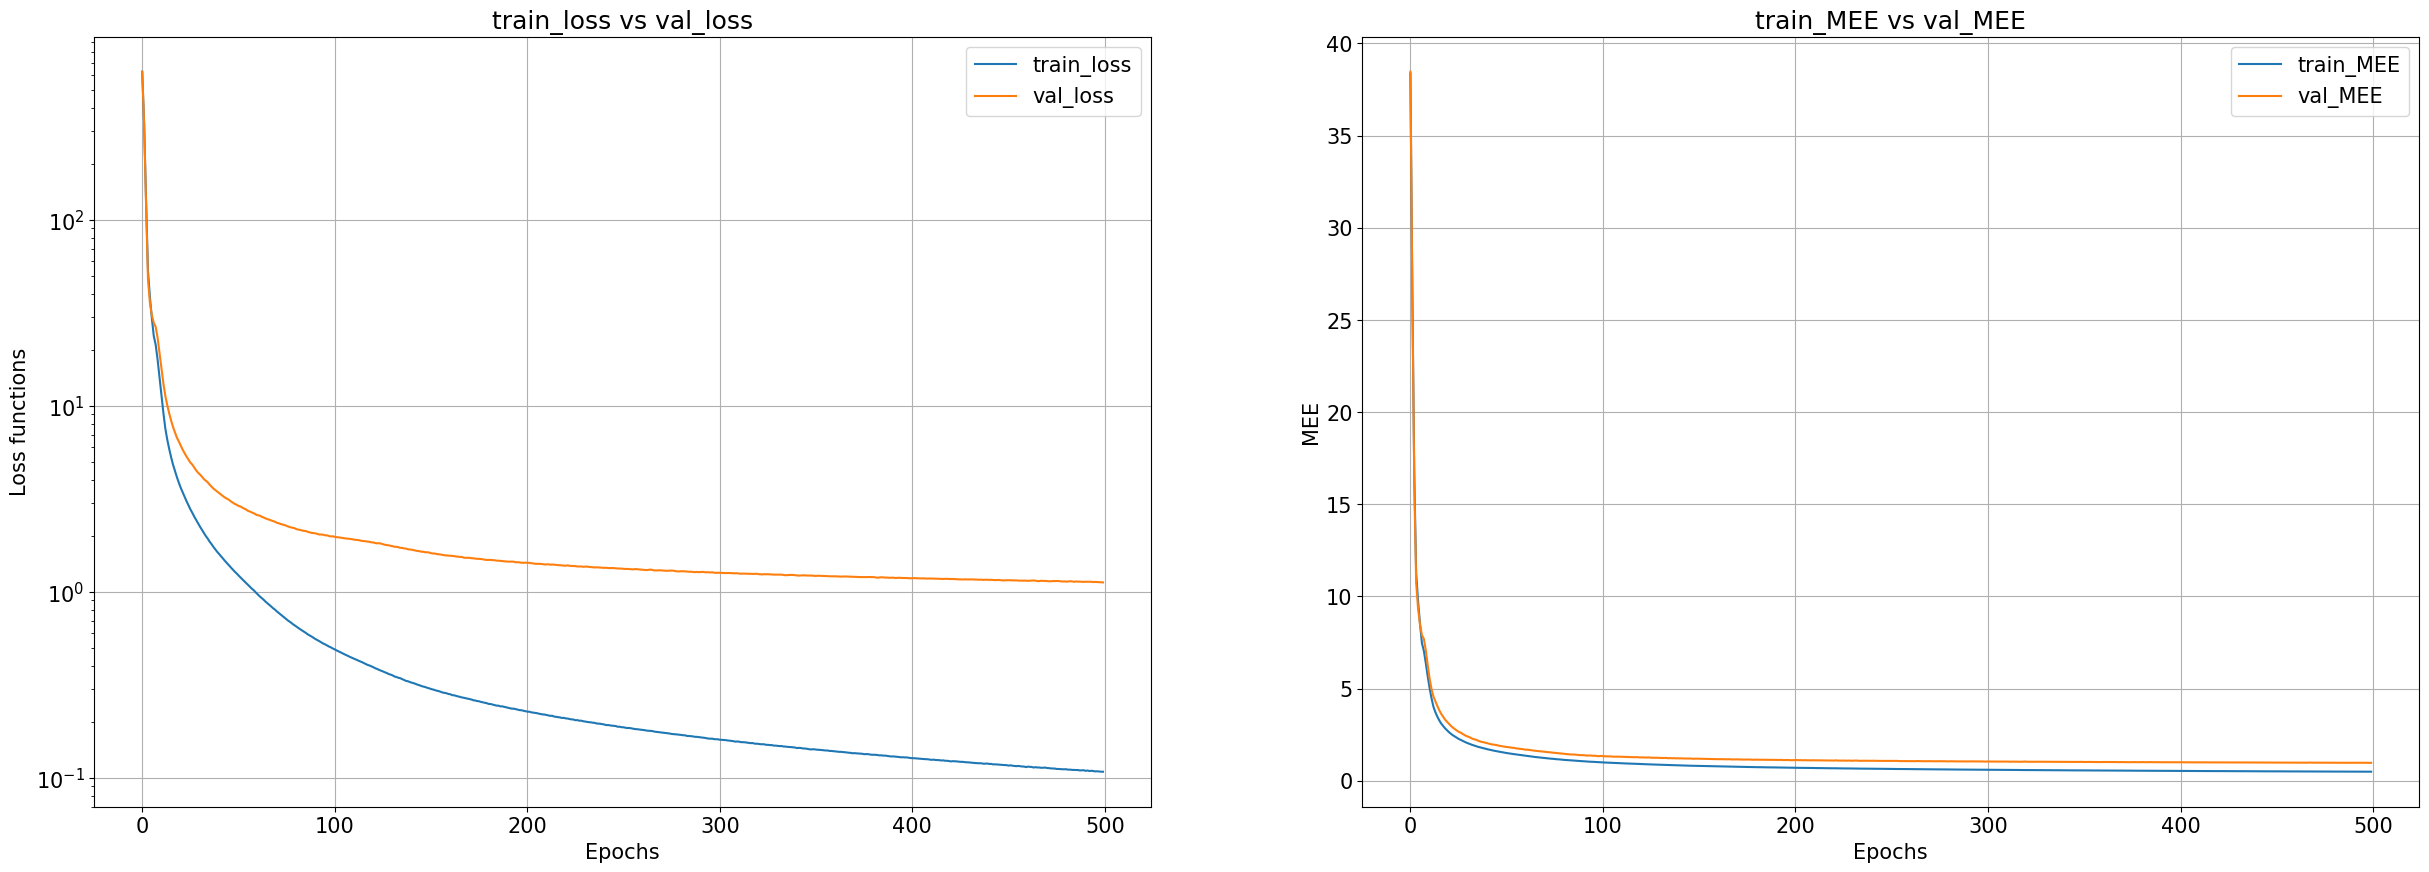

In [42]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_nonorm['train_loss'],label='train_loss')
plt.plot(history_nonorm['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_nonorm['train_MEE'],label='train_MEE')
plt.plot(history_nonorm['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### minmax normalization


Build model


In [43]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training:


In [44]:
np.random.seed(seed)
history_norm = model.train(X_train_norm, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.522e+02, val_loss: 6.512e+02; train_MEE: 3.997e+01, val_MEE: 4.000e+01  lr : 0.001
Epoch 1: train_loss: 4.083e+02, val_loss: 4.042e+02; train_MEE: 3.198e+01, val_MEE: 3.183e+01  lr : 0.001
Epoch 2: train_loss: 1.862e+02, val_loss: 1.788e+02; train_MEE: 2.088e+01, val_MEE: 2.069e+01  lr : 0.001
Epoch 3: train_loss: 7.627e+01, val_loss: 7.205e+01; train_MEE: 1.339e+01, val_MEE: 1.317e+01  lr : 0.001
Epoch 4: train_loss: 4.783e+01, val_loss: 4.441e+01; train_MEE: 1.079e+01, val_MEE: 1.033e+01  lr : 0.001
Epoch 5: train_loss: 3.706e+01, val_loss: 3.626e+01; train_MEE: 9.572e+00, val_MEE: 9.295e+00  lr : 0.001
Epoch 6: train_loss: 2.625e+01, val_loss: 2.932e+01; train_MEE: 7.991e+00, val_MEE: 8.301e+00  lr : 0.001
Epoch 7: train_loss: 2.125e+01, val_loss: 2.504e+01; train_MEE: 7.087e+00, val_MEE: 7.534e+00  lr : 0.001
Epoch 8: train_loss: 1.692e+01, val_loss: 2.041e+01; train_MEE: 6.275e+00, val_MEE: 6.607e+00  lr : 0.001
Epoch 9: train_loss: 1.365e+01, val_loss: 1.71

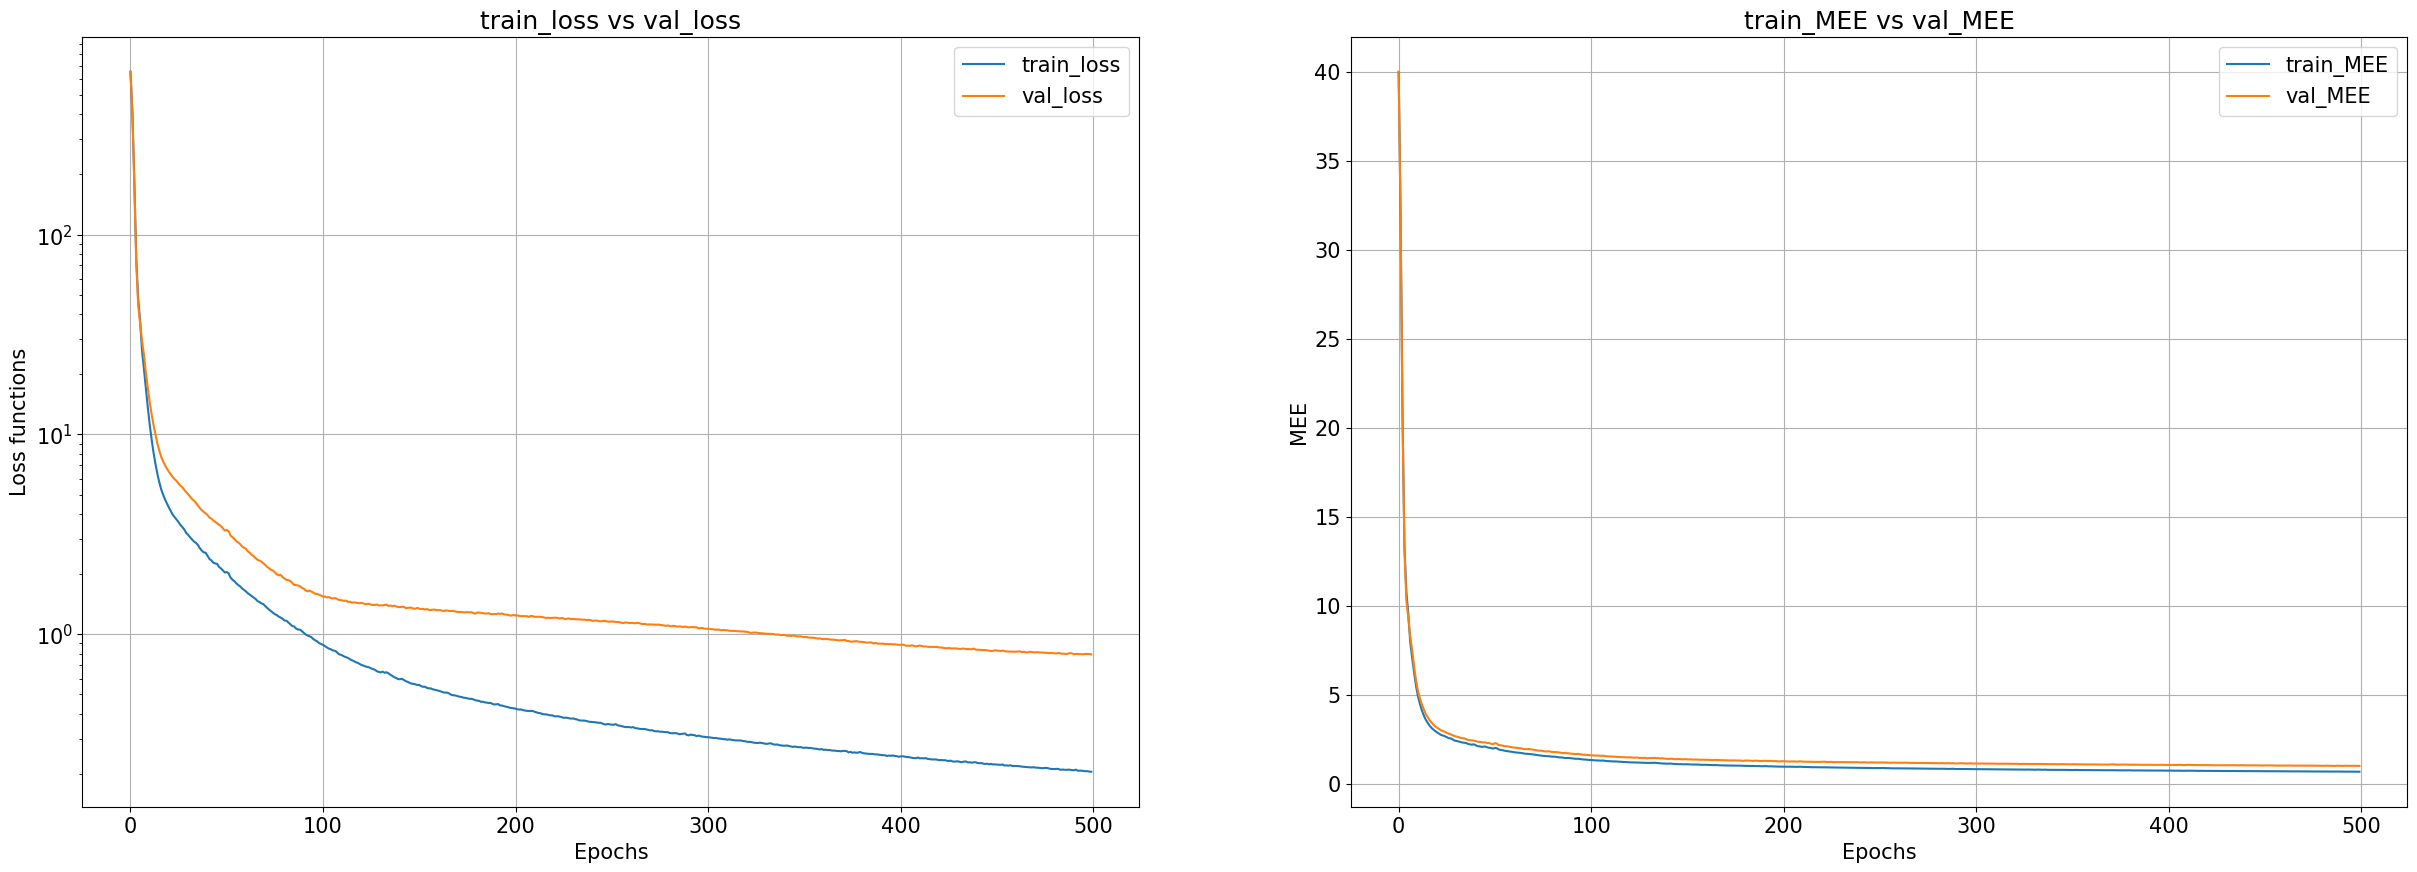

In [45]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_norm['train_loss'],label='train_loss')
plt.plot(history_norm['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_norm['train_MEE'],label='train_MEE')
plt.plot(history_norm['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### standardization


Build model


In [46]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training:


In [47]:
np.random.seed(seed)
history_stand = model.train(X_train_stand, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.262e+02, val_loss: 6.259e+02; train_MEE: 3.848e+01, val_MEE: 3.866e+01  lr : 0.001
Epoch 1: train_loss: 3.422e+02, val_loss: 3.418e+02; train_MEE: 2.764e+01, val_MEE: 2.770e+01  lr : 0.001
Epoch 2: train_loss: 1.343e+02, val_loss: 1.300e+02; train_MEE: 1.731e+01, val_MEE: 1.697e+01  lr : 0.001
Epoch 3: train_loss: 5.469e+01, val_loss: 5.119e+01; train_MEE: 1.145e+01, val_MEE: 1.104e+01  lr : 0.001
Epoch 4: train_loss: 3.519e+01, val_loss: 3.145e+01; train_MEE: 9.243e+00, val_MEE: 8.628e+00  lr : 0.001
Epoch 5: train_loss: 2.346e+01, val_loss: 2.370e+01; train_MEE: 7.526e+00, val_MEE: 7.403e+00  lr : 0.001
Epoch 6: train_loss: 1.788e+01, val_loss: 2.016e+01; train_MEE: 6.496e+00, val_MEE: 6.685e+00  lr : 0.001
Epoch 7: train_loss: 1.352e+01, val_loss: 1.680e+01; train_MEE: 5.603e+00, val_MEE: 5.956e+00  lr : 0.001
Epoch 8: train_loss: 1.024e+01, val_loss: 1.431e+01; train_MEE: 4.820e+00, val_MEE: 5.337e+00  lr : 0.001
Epoch 9: train_loss: 8.487e+00, val_loss: 1.26

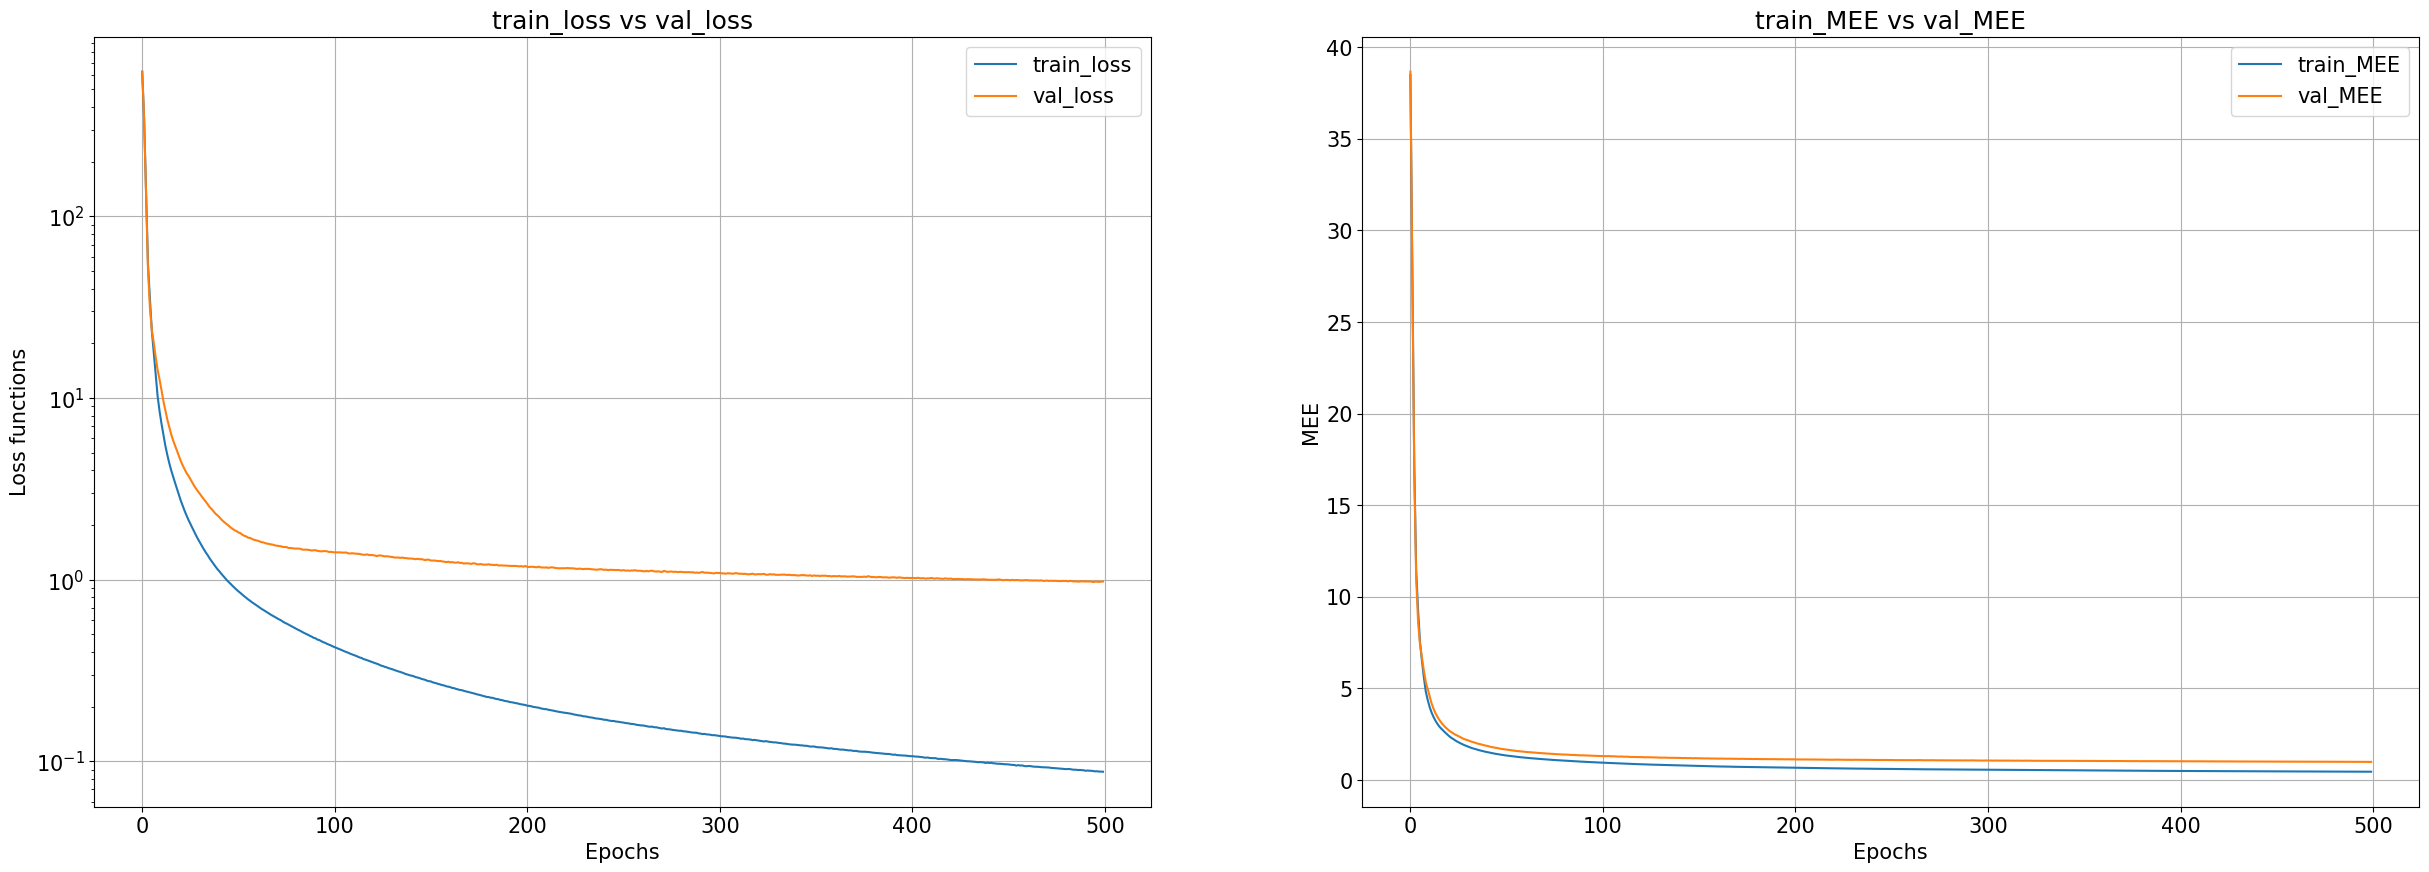

In [48]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_stand['train_loss'],label='train_loss')
plt.plot(history_stand['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_stand['train_MEE'],label='train_MEE')
plt.plot(history_stand['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

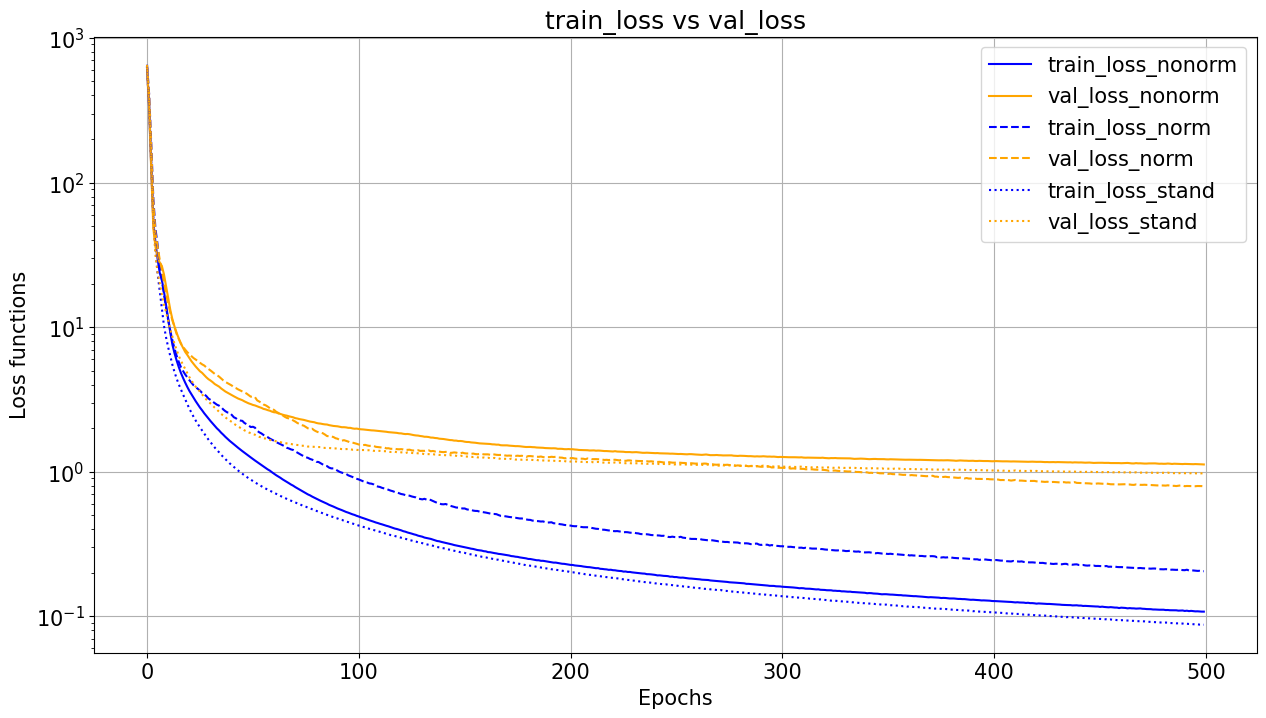

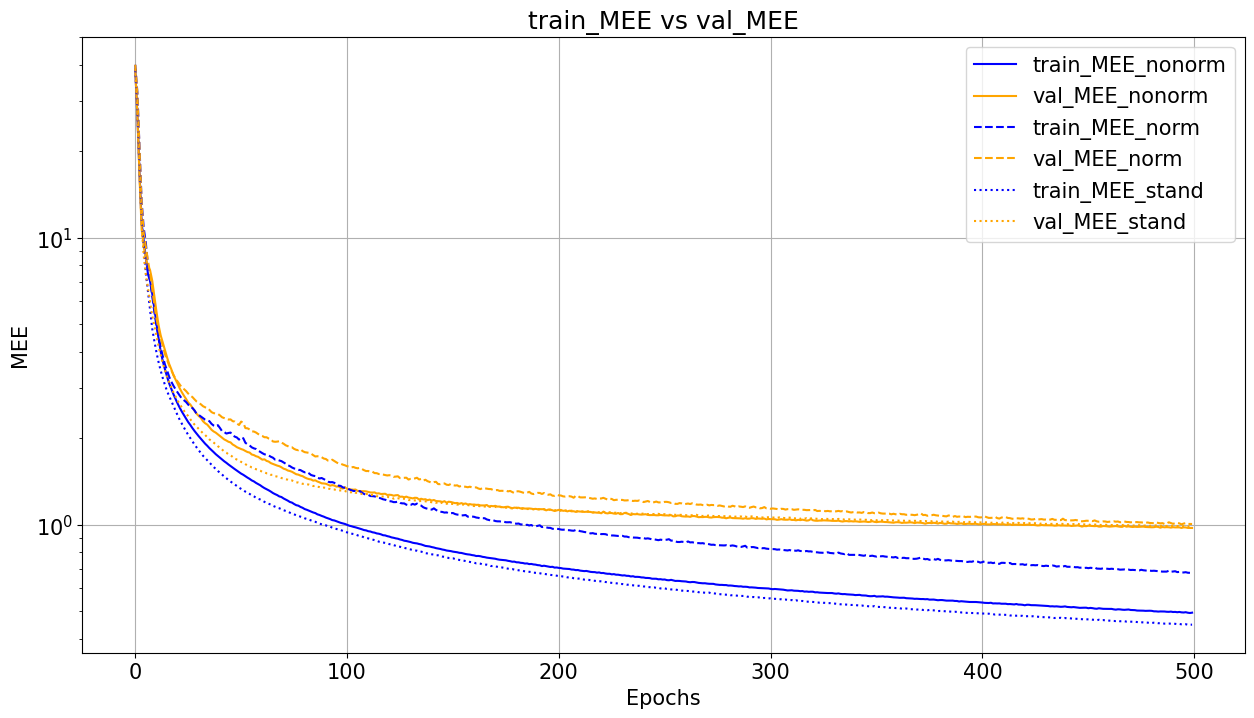

In [56]:
plt.figure(1,figsize=(15,8))
#plt.subplot(1,2,1)
plt.plot(history_nonorm['train_loss'], '-', label='train_loss_nonorm', color='blue')
plt.plot(history_nonorm['val_loss'], '-', label='val_loss_nonorm', color='orange')
plt.plot(history_norm['train_loss'], '--', label='train_loss_norm', color='blue')
plt.plot(history_norm['val_loss'], '--', label='val_loss_norm', color='orange')
plt.plot(history_stand['train_loss'], linestyle='dotted', label='train_loss_stand', color='blue')
plt.plot(history_stand['val_loss'], linestyle='dotted', label='val_loss_stand', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.figure(2,figsize=(15,8))
#plt.subplot(1,2,2)
plt.plot(history_nonorm['train_MEE'], '-',label='train_MEE_nonorm', color='blue')
plt.plot(history_nonorm['val_MEE'], '-', label='val_MEE_nonorm', color='orange')
plt.plot(history_norm['train_MEE'], '--', label='train_MEE_norm', color='blue')
plt.plot(history_norm['val_MEE'], '--', label='val_MEE_norm', color='orange')
plt.plot(history_stand['train_MEE'], linestyle='dotted', label='train_MEE_stand', color='blue')
plt.plot(history_stand['val_MEE'], linestyle='dotted', label='val_MEE_stand', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)